# AI Tools for Actuaries
## Chapter 5: FNN one-hot encoding
### Author: Mario Wuthrich
### Version March, 2025

In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(500)

## Pre-process data for FNN - using one-hot encoding and standardization

In [21]:
def preprocess_onehot(var1, name, dat2):
    XX = pd.get_dummies(dat2[var1])
    XX.columns = [f"{name}{i+1}" for i in range(len(XX.columns))]
    return pd.concat([dat2, XX], axis=1)

def preprocess_continuous(var1, dat2):
    dat2[var1] = pd.to_numeric(dat2[var1])
    dat2[f"{var1}X"] = (dat2[var1] - dat2[var1].mean()) / dat2[var1].std()
    return dat2

def features_preprocess(dat2):
    dat2 = dat2.copy()
    # Convert categorical variables to numeric first
    area_mapping = {cat: i for i, cat in enumerate(dat2["Area"].unique())}
    dat2["Area"] = pd.to_numeric(dat2["Area"].map(area_mapping))
    dat2 = preprocess_continuous("Area", dat2)
    dat2 = preprocess_continuous("VehPower", dat2)
    dat2["VehAge"] = dat2["VehAge"].clip(upper=20)
    dat2 = preprocess_continuous("VehAge", dat2)
    dat2["DrivAge"] = dat2["DrivAge"].clip(upper=90)
    dat2 = preprocess_continuous("DrivAge", dat2)
    dat2["BonusMalus"] = dat2["BonusMalus"].clip(upper=150)
    dat2 = preprocess_continuous("BonusMalus", dat2)
    dat2 = preprocess_onehot("VehBrand", "B", dat2)
    # Create mapping for VehGas
    gas_mapping = {cat: i for i, cat in enumerate(dat2["VehGas"].unique())}
    dat2["VehGasX"] = pd.to_numeric(dat2["VehGas"].map(gas_mapping))
    dat2["Density"] = np.log(dat2["Density"]).round(2)
    dat2 = preprocess_continuous("Density", dat2)
    dat2 = preprocess_onehot("Region", "R", dat2)
    return dat2

## Load and pre-process data

In [22]:
# Load the data
dat = pyreadr.read_r('../../Data/freMTPL2freqClean.rda')  # load the data
dat = dat[None] if None in dat else dat[list(dat.keys())[0]]

print(dat.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678007 non-null  float64 
 1   Exposure    678007 non-null  float64 
 2   Area        678007 non-null  category
 3   VehPower    678007 non-null  int32   
 4   VehAge      678007 non-null  int32   
 5   DrivAge     678007 non-null  int32   
 6   BonusMalus  678007 non-null  int32   
 7   VehBrand    678007 non-null  category
 8   VehGas      678007 non-null  category
 9   Density     678007 non-null  int32   
 10  Region      678007 non-null  category
 11  ClaimTotal  678007 non-null  float64 
 12  ClaimNb     678007 non-null  float64 
 13  LearnTest   678007 non-null  object  
dtypes: category(4), float64(4), int32(5), object(1)
memory usage: 41.4+ MB
None


In [23]:
dat = features_preprocess(dat)

# Split into learn and test sets
learn = dat[dat['LearnTest'] == 'L']
test = dat[dat['LearnTest'] == 'T']

print(learn.info())


<class 'pandas.core.frame.DataFrame'>
Index: 610206 entries, 0 to 610205
Data columns (total 54 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   IDpol        610206 non-null  float64 
 1   Exposure     610206 non-null  float64 
 2   Area         610206 non-null  int64   
 3   VehPower     610206 non-null  int32   
 4   VehAge       610206 non-null  int32   
 5   DrivAge      610206 non-null  int32   
 6   BonusMalus   610206 non-null  int32   
 7   VehBrand     610206 non-null  category
 8   VehGas       610206 non-null  category
 9   Density      610206 non-null  float64 
 10  Region       610206 non-null  category
 11  ClaimTotal   610206 non-null  float64 
 12  ClaimNb      610206 non-null  float64 
 13  LearnTest    610206 non-null  object  
 14  AreaX        610206 non-null  float64 
 15  VehPowerX    610206 non-null  float64 
 16  VehAgeX      610206 non-null  float64 
 17  DrivAgeX     610206 non-null  float64 
 18  BonusMalu

## FNN one-hot encoded categorical features

In [24]:
# define the FNN with three hidden layers
def create_fnn(seed, q0, train):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    
    train_hidden = train[0].lower() == 'true'
    train_output = train[1].lower() == 'true'

    design_input = keras.layers.Input(shape=(q0[0],), dtype='float32')
    volume_input = keras.layers.Input(shape=(1,), dtype='float32')
    
    x = design_input
    x = keras.layers.Dense(q0[1], activation='tanh', trainable=train_hidden)(x)
    x = keras.layers.Dense(q0[2], activation='tanh', trainable=train_hidden)(x)
    x = keras.layers.Dense(q0[3], activation='tanh', trainable=train_hidden)(x)
    x = keras.layers.Dense(1, activation='exponential', trainable=train_output)(x)
    
    output = keras.layers.Multiply()([x, volume_input])
    
    model = keras.Model(inputs=[design_input, volume_input], outputs=output)
    return model

In [25]:
# define the Poisson deviance (scaled by 10^2 for better visibility)
def poisson_deviance(pred, obs):
    return 200 * (np.sum(pred) - np.sum(obs) + np.sum(np.log((obs/pred)**obs))) / len(pred)

In [26]:
# Calculate homogeneous frequency
mu_hom = learn['ClaimNb'].sum() / learn['Exposure'].sum()

# Prepare features
features = ['AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'BonusMalusX',
           'VehGasX', 'DensityX'] + \
           [f'B{i}' for i in range(1, 12)] + \
           [f'R{i}' for i in range(1, 23)]

q0 = len(features)
print(f"Number of features: {q0}")

# Prepare matrices and ensure float32 dtype
X_learn = learn[features].astype('float32').values
X_test = test[features].astype('float32').values
V_learn = learn['Exposure'].astype('float32').values.reshape(-1, 1)
V_test = test['Exposure'].astype('float32').values.reshape(-1, 1)
Y_learn = learn['ClaimNb'].astype('float32').values.reshape(-1, 1)
Y_test = test['ClaimNb'].astype('float32').values.reshape(-1, 1)

# Define network architecture
q00 = [q0, 20, 15, 10]
seed = 100

# Create model
train = ['true', 'true']
model = create_fnn(seed, q00, train)
model.summary()


Number of features: 40


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        820 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │        315 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         11 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,306 (5.10 KB)

 Trainable params: 1,306 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:

# Homogeneous case not considering any covariates
w0 = model.get_weights()
w0[-2] = np.zeros_like(w0[-2])
w0[-1] = np.log(mu_hom) * np.ones_like(w0[-1])
model.set_weights(w0)

test_hom = model.predict([X_test, V_test], batch_size=10**6)
learn_hom = model.predict([X_learn, V_learn], batch_size=10**6)

print("Poisson Deviance (Train, Test):", 
      round(poisson_deviance(learn_hom, Y_learn), 3),
      round(poisson_deviance(test_hom, Y_test), 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Poisson Deviance (Train, Test): 25.213 25.445


## Train the model

Epoch 1/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1592 - val_loss: 0.1558
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1563 - val_loss: 0.1555
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1560 - val_loss: 0.1553
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 - val_loss: 0.1551
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1557 - val_loss: 0.1549
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1556 - val_loss: 0.1548
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1554 - val_loss: 0.1547
Epoch 8/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1553 - val_loss: 0.1545
Epoch 9/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1552 - val_loss: 0.1544
Epoch 10/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1551 - val_loss: 0.1543
Epoch 11/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1549 - val_loss: 0.1542
Epoch 12/200
110/110 ━━━━━━━━━━━━━━━━━━━━

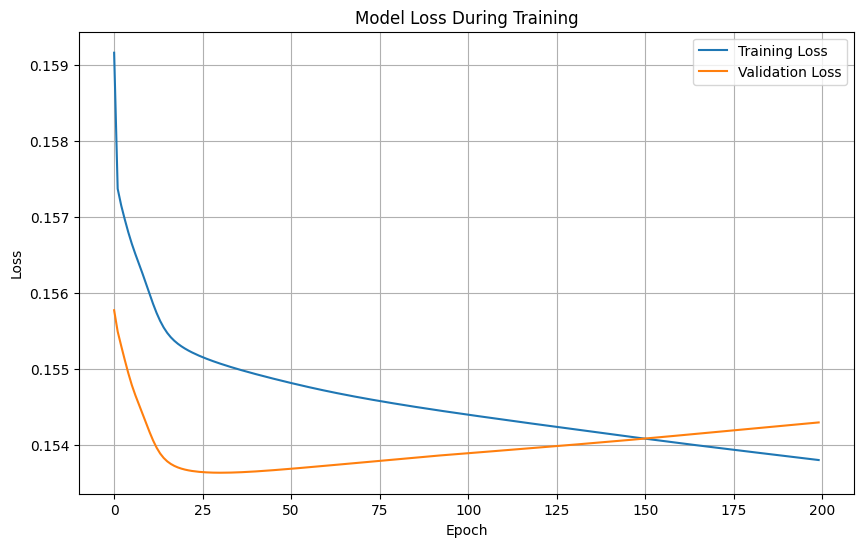

In [28]:
# Create checkpoint callback
import os
if not os.path.exists('./Networks'):
    os.makedirs('./Networks')

checkpoint_path = f'./Networks/FNN1_{seed}.weights.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                           monitor='val_loss',
                                           save_best_only=True,
                                           save_weights_only=True)

# Compile model
model.compile(loss='poisson', optimizer='nadam')

# Train model
history = model.fit([X_learn, V_learn], Y_learn,
                   validation_split=0.1,
                   batch_size=5000,
                   epochs=200,
                   verbose=1,
                   callbacks=[checkpoint])

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

## Evaluate Results

In [29]:
# Load best weights and evaluate
model.load_weights(checkpoint_path)
w2 = model.get_weights()
learn_nn = model.predict([X_learn, V_learn], batch_size=10**6)
test_nn = model.predict([X_test, V_test], batch_size=10**6)

print("Poisson Deviance (Train, Test):",
      round(poisson_deviance(learn_nn, Y_learn), 3),
      round(poisson_deviance(test_nn, Y_test), 3))

print("Balance Property:",
      round(mu_hom, 4),
      round(np.sum(learn_nn)/np.sum(learn['Exposure']), 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Poisson Deviance (Train, Test): 23.793 23.855
Balance Property: 0.0736 0.0735


## Balance Property Adjustment

In [30]:
# Create model that has only a trainable output layer
train = ['false', 'true']
model = create_fnn(seed, q00, train)
model.set_weights(w2)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.1548
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1548
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1548
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1548
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1548
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1548
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1548
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1548
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1548
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1548
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1548
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1548
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1548
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1548
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1548
Epoch 16/200
1/1 ━

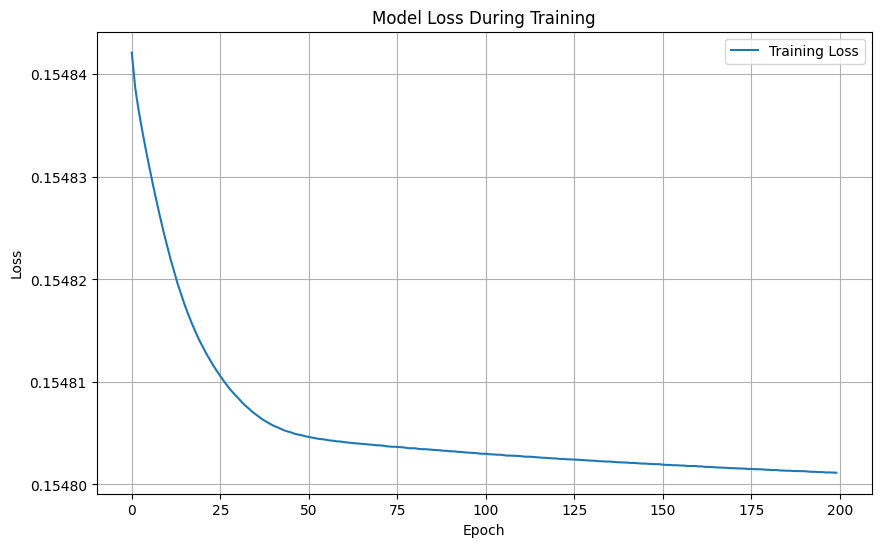

In [31]:
# Compile model
model.compile(loss='poisson', optimizer='nadam')

# Train model (note that we train a Poisson model with canonical link)
history = model.fit([X_learn, V_learn], Y_learn,
                   validation_split=0,
                   batch_size=len(Y_learn),
                   epochs=200,
                   verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

In [32]:
learn_nn_reg = model.predict([X_learn, V_learn], batch_size=10**6)
test_nn_reg = model.predict([X_test, V_test], batch_size=10**6)

print("Poisson Deviance (Train, Test):",
      round(poisson_deviance(learn_nn_reg, Y_learn), 3),
      round(poisson_deviance(test_nn_reg, Y_test), 3))

print("Balance Property:",
      round(mu_hom, 4),
      round(np.sum(learn_nn_reg)/np.sum(learn['Exposure']), 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Poisson Deviance (Train, Test): 23.785 23.84
Balance Property: 0.0736 0.0736


In [33]:
path2 = f'./Networks/FNN1_reg_{seed}.weights.h5'
model.save_weights(path2)